In [1]:
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image

# Custom dataset that inherits from 
class Food11Dataset(Dataset):
    def __init__(self, dir, transform=None):
        self.dir = dir
        self.transform = transform
        self.file_list = [file for file in os.listdir(dir) if file.endswith('.jpg')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = os.path.join(self.dir, self.file_list[idx])
        
        image = Image.open(path)

        if self.transform:
            image = self.transform(image)

        label = int(self.file_list[idx].split('_')[0])

        return image, label

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 8)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 8)

        self.fc1 = nn.Linear(16 * 58 * 58, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #print(f"conv1: {x.shape}")
    
        x = self.pool(x)
        #print(f"pool: {x.shape}")

        x = self.conv2(x)
        x = F.relu(x)
        #print(f"conv2: {x.shape}")

        x = self.pool(x)
        #print(f"pool: {x.shape}")

        # -1 means that pytorch will find it automatically
        x = x.view(-1, 16 * 58 * 58)

        x = self.fc1(x)
        x = F.relu(x)
        #print(f"fc1: {x.shape}")

        x = self.fc2(x)
        x = F.relu(x)
        #print(f"fc2: {x.shape}")

        x = self.fc3(x)
        #print(f"fc3: {x.shape}")

        return x

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = Food11Dataset('food11/training', transform=transform)

validate_data = Food11Dataset('food11/validation', transform=transform)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

validate_dataloader = DataLoader(validate_data, batch_size=64, shuffle=True)

classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 
           'Rice', 'Seafood','Soup', 'Vegetable/Fruit')    

In [9]:
# Test the network on the validation data
import torch
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test(model, dataloader):

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    return accuracy


# Run the tests
model = Network().to(DEVICE)
model.load_state_dict(torch.load('last.pth'))

accuracy = test(model, validate_dataloader)
print(f"Accuracy of the network on the validation images: {accuracy:.4f}%")


100%|██████████| 54/54 [52:49<00:00, 58.69s/it]

Accuracy of the network on the validation images: 37.7259%


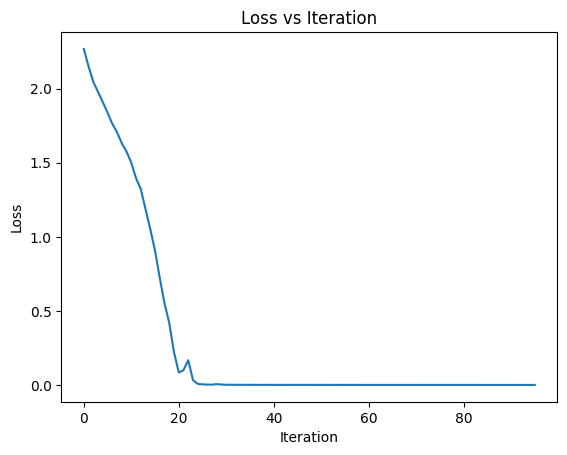

In [1]:
# Plot loss from loss.txt

import matplotlib.pyplot as plt

f = open("loss.txt", "r")

loss = []

for x in f:
    loss.append(float(x))


plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.show()
